<div style="text-align: center; font-size:xx-large; font-weight:bold;">King County 지역의 주택 거래 데이터를 이용한 주택 가격 예측</div>

<br>

<div style="text-align: center; font-size:x-large;">기계학습 기말 레포트</div>

<div style="text-align: center; font-size:large;">2024. 12</div>

## **1. 개요**

---

&nbsp; 해당 분석은 **kaggle**의 **House Sales in King County, USA** 데이터셋<sup>[1](#dataset)</sup>을 사용하여 진행되었으며, 사용된 데이터셋은 워싱턴 주에서 가장 인구가 많은 King County 지역에서 2014년 5월부터 2015년 5월까지 이뤄진 실제 주택 거래 정보를 가지고 있다. 여기에는 예측변수인 판매 가격뿐만 아니라 판매 일자, 완공 년도, 주변 입지 및 품질에 대한 지표 등이 포함되며, 주택이 강과 바다 등 물가를 바라보는 여부를 제외하면 모든 변수를 수치형 변수로 취급할 수 있다.

<p align="center" style="color:gray">
    <div style="text-align: center;">
      <img style="margin:10px 0 0 0" src="https://github.com/HollyRiver/ML2024/blob/main/hw/%EA%B8%B0%EB%A7%90%20%EB%B0%9C%ED%91%9C/graphics/King%20County.png?raw=true" alt="Washington-King County" width=1200 /> <br>
         Washington주의 King County 지역. <mark>Washington D.C가 아니다.</mark>
    </div>
</p>

## **2. 데이터 설명**

---

&nbsp; **House Sales in King County, USA** 데이터셋(이하, 주택 판매 데이터셋)은 총 $21,613$건의 주택 거래에 대한 $21$개의 변수를 가지고 있다. 모든 거래 내역에 대해서 결측치는 존재하지 않았으며, 각 변수들에 대한 설명은 아래와 같다.

|변수|타입|설명|세부사항|
|:-|:-|:-|:-|
|id|integer|주택 판매 고유번호||
|date|object|주택 판매 일자(`YYYYMMDDT000000`)|일별 데이터|
|bedrooms|integer|침실의 수||
|bathrooms|float|화장실의 수|소수점(0.5)은 목욕 시설이 없는 화장실을 의미|
|sqft_living|integer|주택 내부 총 생활공간의 면적$(\text{ft}^2)$||
|sqft_lot|integer|가용한 토지공간의 면적$(\text{ft}^2)$||
|floors|float|주택의 층수|소수점(0.5)은 다락과 같은 부가적인 공간을 의미|
|view|integer|주택의 전망에 대한 평가 지수|0부터 4까지의 값을 가지며, 클수록 좋음|
|condition|integer|주택 상태에 대한 평가 지수|1부터 5까지의 값을 가지며, 클수록 좋음|
|grade|integer|주택의 건축 및 디자인에 대한 전반적인 품질 수준 평가 지수|1부터 13까지의 값을 가지며, 클수록 좋음|
|sqft_above|integer|지면 위 주택 내부 공간의 면적$(\text{ft}^2)$||
|sqft_basement|integer|지면 아래 주택 내부 공간의 면적$(\text{ft}^2)$||
|yr_built|integer|주택 완공년도||
|yr_renovated|integer|주택을 마지막으로 보수한 연도|0은 완공 이후 보수하지 않았음을 의미|
|zipcode|integer|주택이 속하는 우편번호 지역||
|lat|float|주택 위치의 위도||
|long|float|주택 위치의 경도||
|sqft_living15|integer|가장 가까운 15개 가구의 주택 내부 총 생활공간의 면적$(\text{ft}^2)$||
|sqft_lot15|integer|가장 가까운 15개 가구의 총 가용 토지공간의 면적$(\text{ft}^2)$||
|waterfront|binary|주택이 물가를 바라보고 있는지의 여부|1은 물가를 바라보는 것을 의미|
|||||
|**price**|**float**|**주택 판매 가격($)**|**예측변수**|

&nbsp; 해당 분석의 목적은 예측변수인 주택 가격(`price`)과 다른 설명변수 간 관계를 파악하고, 예측에서의 오차를 최소화하는 것이다. 이에 따라 모형의 평가를 위한 데이터셋을 구분할 필요가 존재하였고, 이는 데이터셋을 셔플하여 `test` 데이터셋이 $3$인 $7:3$의 비율로 쪼갬으로써 해결하였다. 다중선형회귀모형을 사용하여 각 설명변수가 예측변수에 미치는 영향을 대략적으로 파악할 것이고, 수치형 설명변수가 대부분이므로 `XGBoost`를 이용하여 예측을 수행하는 것이 적절하리라 판단된다. 최적의 모형을 찾기 위해 교차검증을 통한 변수 및 초매개변수 선택 과정을 거쳤으며, 성능 지표로는 $\text{RMSE}$를 사용하였다. 분석 및 시각화에는 python의 `sklearn`, `xgboost`, `matplotlib`, `plotly` 라이브러리를 사용하였다.

## **3. 데이터 시각화 및 탐색적 자료 분석**

---

### **A. 예측변수 주택 판매 가격의 분포**

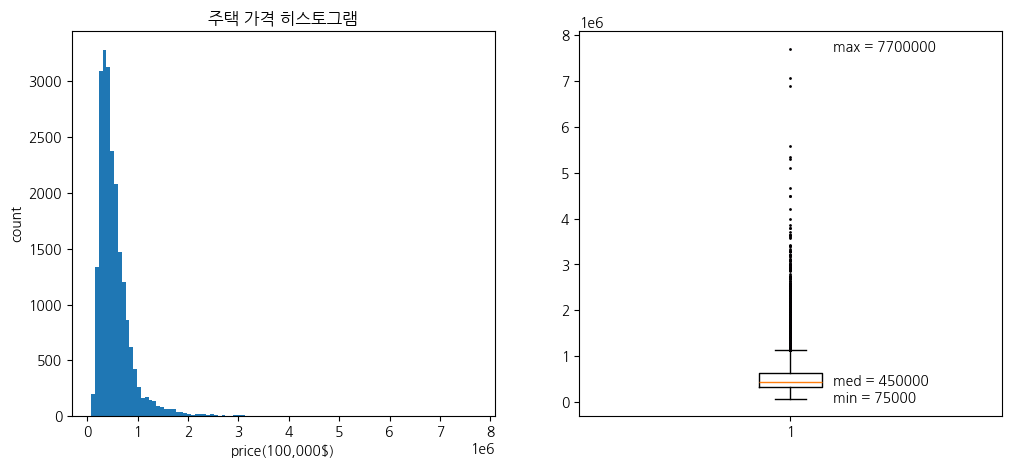

&nbsp; 주택 가격의 단변량 분포를 히스토그램과 상자 그림을 통해 시각화하였다. 거래 가격이 높은 쪽에서 상당히 많은 이상치가 존재하여 전형적인 오른쪽으로 기울어진 분포를 띄고 있다. 선형 모형 구성 이전에 정규화 과정을 거치는 것이 성능 향상에 도움을 줄 수 있다.

### **B. 각 설명변수들과 예측변수 간 관계 파악**

`-` 개별 설명변수(구매일자 제외)와 예측변수 간 산점도

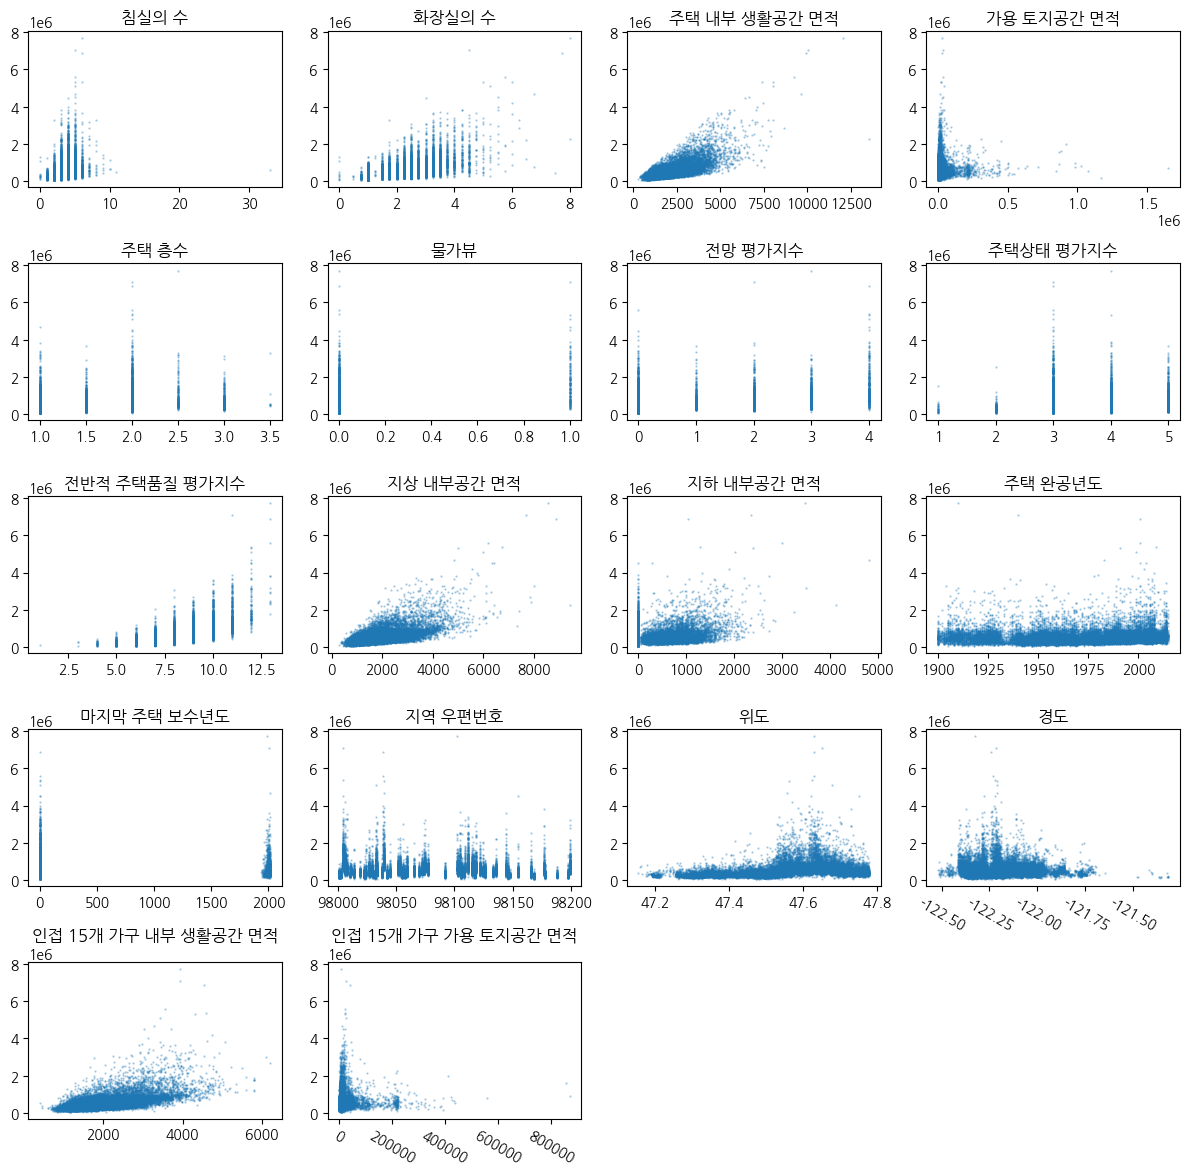

&nbsp; 개별 설명변수와 예측변수 간 관계를 파악하기 위해, 구매 일자를 제외한 각 설명변수와 반응변수 간 산점도를 그려보았다. 모든 그래프에서 $x$축은 주택가격이다. 육안 상 침실의 수, 화장실의 수, 주택 내부 생활공간 면적, 전반적 주택품질 평가지수, 지상 내부공간 면적, 지하 내부공간 면적, 인접 15개 가구 내부 생활공간 면적이 주택가격과 관련이 있는 것으로 보인다.

`-` 구매 일자 관련 시각화

![monthly price boxplot.png](<attachment:monthly price boxplot.png>)
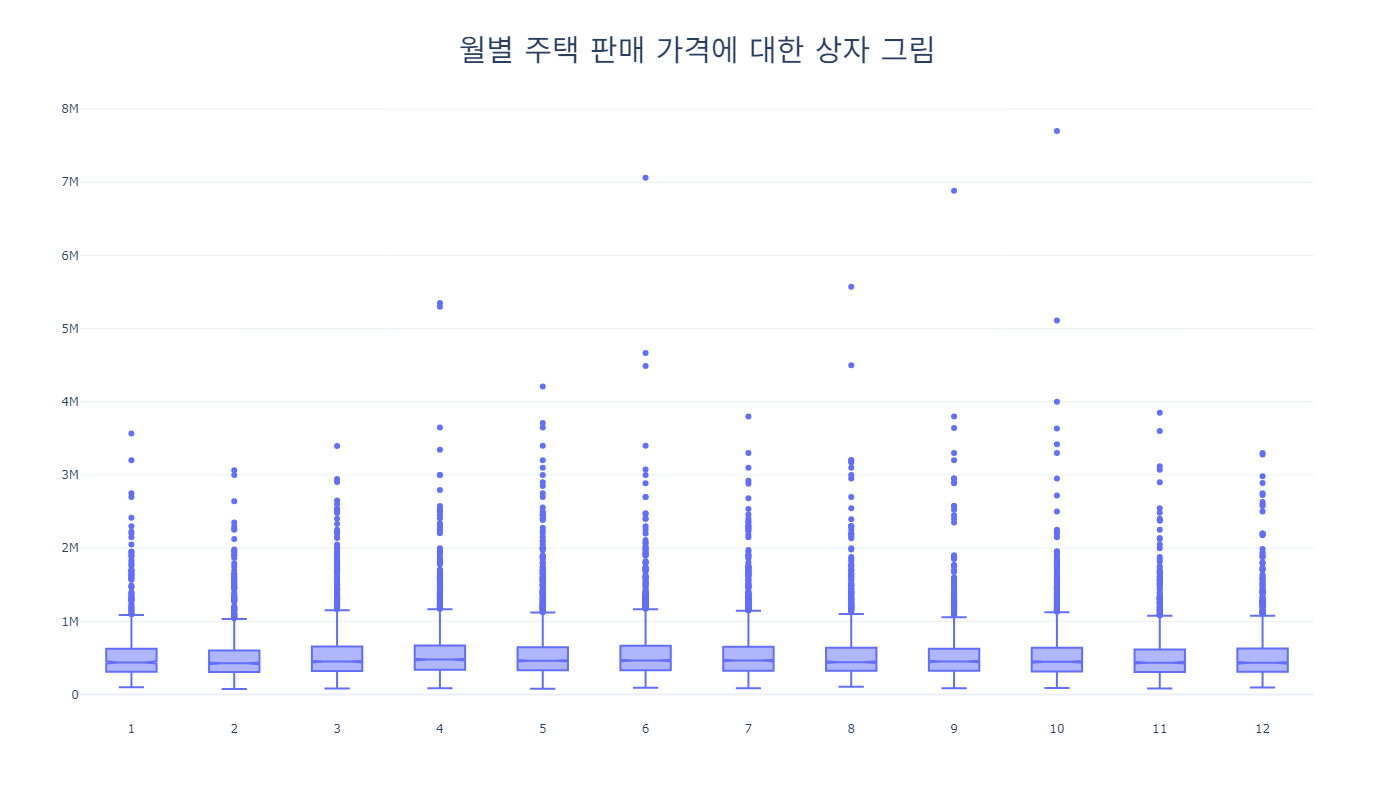

&nbsp; 월별 판매 가격의 변화량을 살펴보았으나, 거의 변화가 없었다. 단, notched 표시로 중위수의 신뢰구간을 살펴보았을 때, 신뢰구간이 겹치지 않는 월들이 분명히 존재하므로, 해당 변수가 유의하지 않다고 말하기엔 무리가 있다.

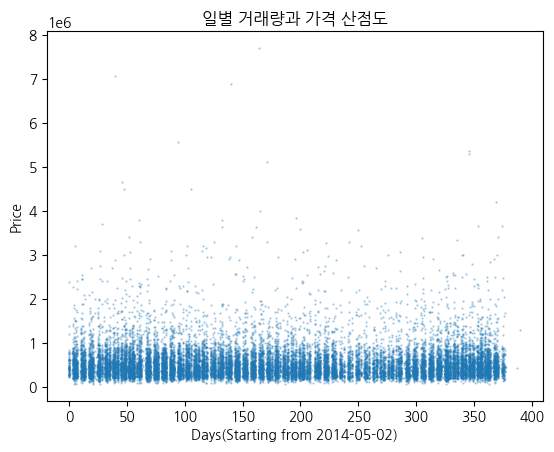

&nbsp; 거래일을 시작일인 `2014-05-02`부터의 날짜 차이로 변환하여 시각화하였다. 시간이 지남에 따라 차이가 명확하게 드러나지 않았다. 이에 따라 해당 설명변수가 예측변수에 큰 영향을 미치지는 못할 것이라 예상할 수 있다.

### **C. 변수 간 선형 상관계수 히트맵(절대값 스케일)**

![vars heatmap.png](<attachment:vars heatmap.png>)
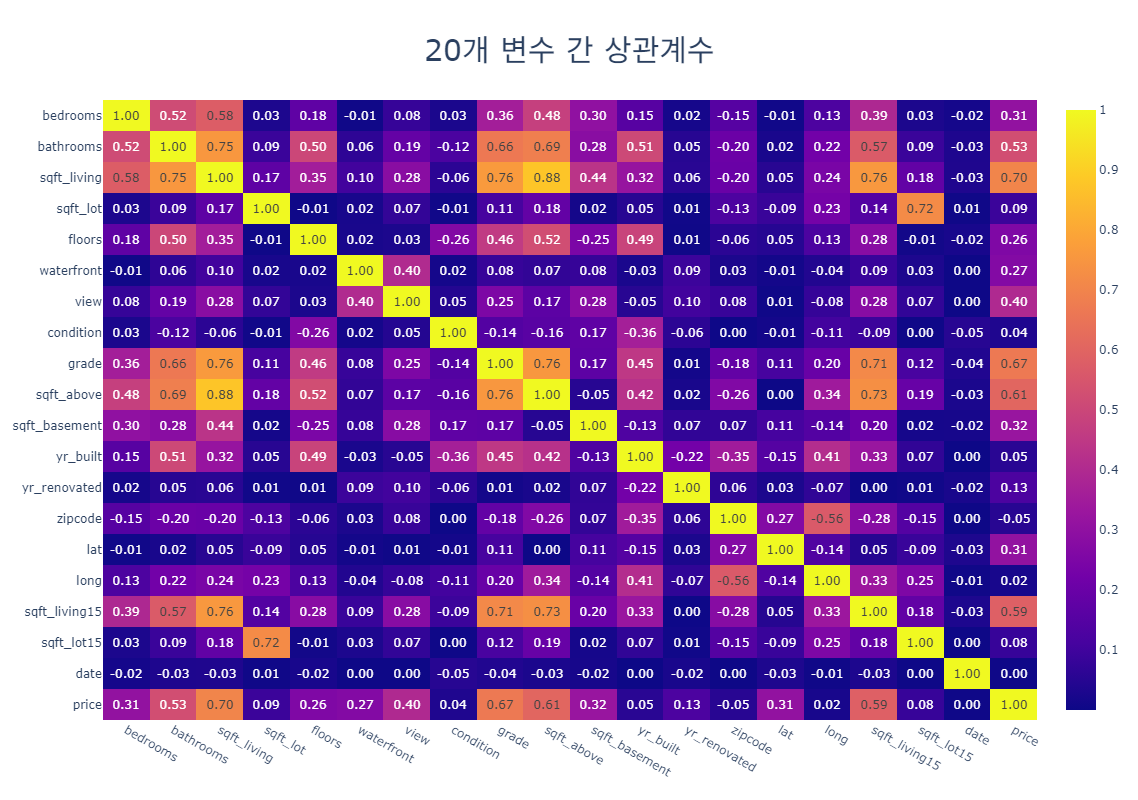

&nbsp; 변수 간 선형 상관관계를 파악하기 위해, 상관계수의 절대값을 히트맵으로 시각화하였다. 예측변수인 `price`와의 상관계수가 가장 낮은 세 변수는 차례대로 `date`, `long`, `condition`이었고, 그 중 `date` 변수는 타 변수들과의 상관계수도 매우 낮기 때문에 선형에선 독립적인 변수라고 생각된다.

&nbsp; 또한, `sqft_living`의 경우, `bathrooms`, `grade`, `sqft_above`, `sqft_living15`에 대하여 $0.7$ 이상의 높은 상관계수를 가졌다. 각 변수들이 실내 공간의 면적, 화장실의 수, 주택의 전반적 품질, 지하 공간의 면적, 인근 15개 주택 면적임을 생각하면, 생활 공간과 관련된 변수가 많기 때문에 설명변수 간 상관성은 상당히 높을 것이다. 따라서 다중공선성 문제에 유의하여 분석할 필요가 있다.

## **4. 일반 모형 적용 : 다중 선형 회귀모형**

---

&nbsp; `sklearn` 모듈을 이용하여 다중 선형 회귀모형을 적합하고, `statmodel` 모듈을 통해 각 설명변수의 유의성에 대한 $\text{ANOVA}$ 테이블을 산출해보았다. 모형 적합에 사용할 설명변수 중 `date`는 $1$월을 기준범주로 한 월별 더미 변수로 처리하여 모형에 추가하였고, 해당 변수들의 이름은 `month2 ~ month12`로 설정하였다. 설명변수들의 차수는 전부 $1$로 설정하였다.

```
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      7.575e+06   3.54e+06      2.141      0.032    6.39e+05    1.45e+07
bedrooms       -3.51e+04   2234.349    -15.710      0.000   -3.95e+04   -3.07e+04
bathrooms      4.274e+04   3889.469     10.988      0.000    3.51e+04    5.04e+04
sqft_living     110.5253      2.729     40.501      0.000     105.176     115.874
sqft_lot          0.1265      0.056      2.274      0.023       0.017       0.235
floors         9049.4422   4289.175      2.110      0.035     642.141    1.75e+04
waterfront     6.287e+05   2.01e+04     31.253      0.000    5.89e+05    6.68e+05
view           4.807e+04   2570.042     18.705      0.000     4.3e+04    5.31e+04
condition      2.899e+04   2819.808     10.282      0.000    2.35e+04    3.45e+04
grade          9.665e+04   2593.196     37.269      0.000    9.16e+04    1.02e+05
sqft_above       70.9692      2.705     26.240      0.000      65.668      76.271
sqft_basement    39.5561      3.207     12.333      0.000      33.270      45.843
yr_built      -2695.5188     87.213    -30.907      0.000   -2866.468   -2524.570
yr_renovated     18.7430      4.408      4.252      0.000      10.102      27.383
zipcode        -580.5128     39.892    -14.552      0.000    -658.706    -502.320
lat            5.985e+05   1.29e+04     46.532      0.000    5.73e+05    6.24e+05
long          -2.085e+05   1.59e+04    -13.137      0.000    -2.4e+05   -1.77e+05
sqft_living15    20.8194      4.147      5.020      0.000      12.691      28.948
sqft_lot15       -0.4071      0.088     -4.651      0.000      -0.579      -0.236
month_10       1.753e+04   9551.069      1.836      0.066   -1187.023    3.63e+04
month_11       9371.6459   1.01e+04      0.925      0.355   -1.05e+04    2.92e+04
month_12       3382.4909   9965.958      0.339      0.734   -1.62e+04    2.29e+04
month_2        1.688e+04   1.03e+04      1.633      0.103   -3385.975    3.72e+04
month_3        4.131e+04   9546.847      4.327      0.000    2.26e+04       6e+04
month_4        4.601e+04   9291.183      4.952      0.000    2.78e+04    6.42e+04
month_5        1.941e+04   9180.863      2.115      0.034    1418.210    3.74e+04
month_6        8085.4758   9308.660      0.869      0.385   -1.02e+04    2.63e+04
month_7        1.225e+04   9329.499      1.313      0.189   -6034.326    3.05e+04
month_8        1.068e+04   9526.824      1.122      0.262   -7988.983    2.94e+04
month_9        5031.5007   9617.267      0.523      0.601   -1.38e+04    2.39e+04
=================================================================================
```

&nbsp; 적합 결과, 해당 모형의 테스트 데이터에서의 $\text{RMSE}$는 $196439.3155$였으며, 유의수준 $\alpha = 0.05$에서 `date`와 관련된 변수를 제외하면 모두 예측변수 `price`에 유의한 영향을 미치고 있다. `date`와 관련된 월별 더미 변수들도 $3, 4, 5$월의 경우 기준범주인 $1$월과 유의한 차이를 보였으며, 이에 따라 각각 $3, 4, 5$월은 $1$월보다 평균적으로 $\$41309, ~ \$46012, ~\$19414$만큼 비싼 가격을 받았다고 말할 수 있다.

&nbsp; 또한, `date` 변수를 일별 수치형 변수로 처리하였을 때의 테스트 $\text{RMSE}$는 $196509.2480$로, 범주형 변수를 더미변수 처리한 것에 비해 더 낮은 성능을 보였다. 이는 `date`가 $1$차 선형 구조를 띄지 않고 있음을 시사한다.

## **5. 벌점 함수 모형 적용 : RIDGE**

---

&nbsp; 상관성이 높은 설명변수가 존재하기 때문에, 벌점 함수 모형 중 이러한 상황에 효과적인 RIDGE Regression을 적용하였다. 범주형 설명변수로 처리된 `date` 변수를 제외하고 전부 표준화로 스케일을 조정했으며, 하이퍼파라미터인 $\lambda$값은 $10\text{-fold}$ 교차 검증으로 구한 CV MSE를 가장 낮게 하는 경우와, 해당 MSE에서 1-se rule을 적용하여 구한 경우를 모두 구한 후 비교하기로 하였다.

&nbsp; 또한, 예측변수인 `price`의 분포가 오른쪽으로 기울어져 있으므로, 선형에서 분석의 성능을 향상시키고자 파워 변환을 고려할 수 있다. 이 경우 적합된 모형에서의 예측값에 역변환을 하여 원래 스케일로 복원한 뒤 성능지표를 산출하여 비교하였다.

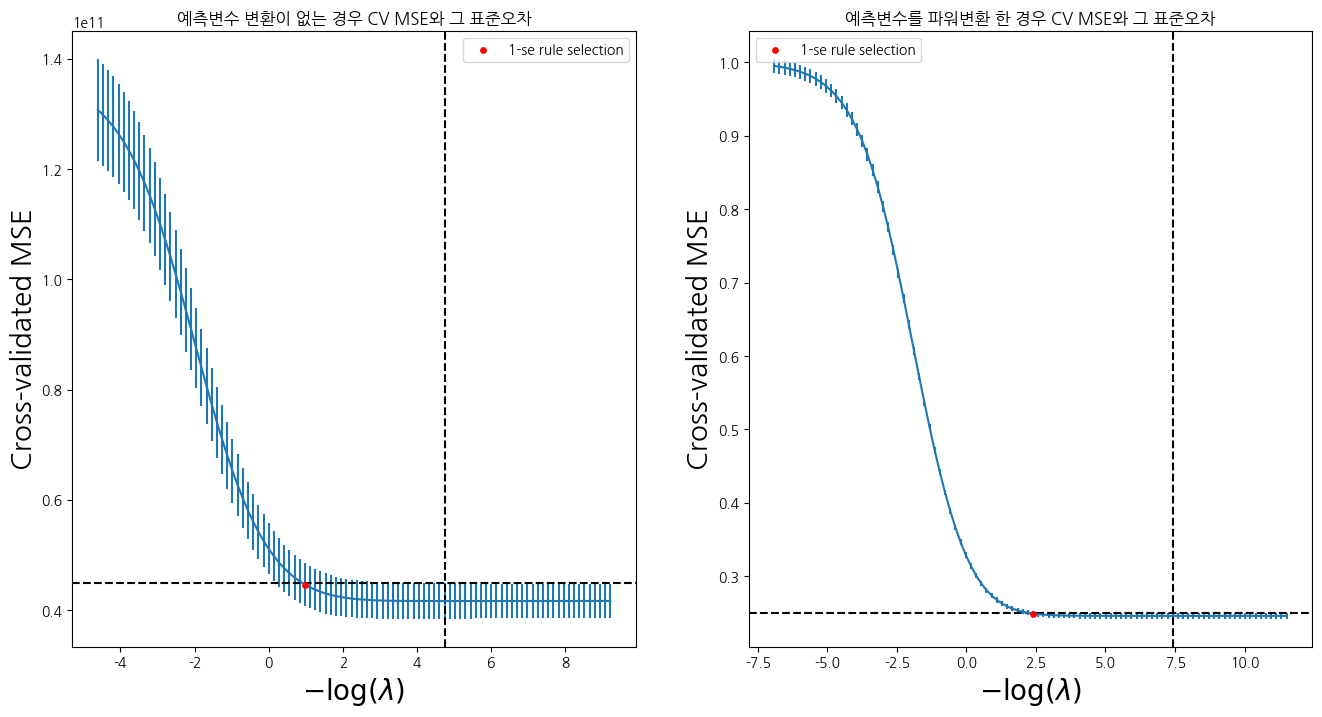

&nbsp; 그 결과, 예측변수 변환이 없는 경우에선 $\lambda = 0.0087$일 때 CV MSE가 가장 낮았으며, 1-se rule로 선택된 $\lambda = 0.37649$였다. 예측변수를 파워변환 한 경우에는 $\lambda = 0.0006$일 때 CV MSE가 가장 낮았으며, 1-se rule을 적용하면 $\lambda = 0.09112$였다.

&nbsp; 각각의 $\lambda$값과 변환에 대하여 모형을 구성한 뒤, `test dataset`에서의 RMSE를 계산하였다. 아래는 그 결과이다.

|예측변수 변환 여부|1-se rule 적용 여부|RMSE|
|:-:|:-:|:-:|
|변환 없음|적용 안함|$196355.4463$|
|파워 변환|적용 안함|$218913.8812$|
|변환 없음|1-se rule 적용|$203056.3837$|
|파워 변환|1-se rule 적용|$289343.2780$|

&nbsp; 예측변수를 그대로 사용하여 적합하고, 1-se rule을 적용하지 않았을 때의 test RMSE가 가장 작았다. 해당 경우에서의 RMSE는 다중선형회귀에서의 값 $196439.3155$와 비교하면 더 낮으므로, RIDGE regression model의 성능이 더 좋다고 판단할 수 있다.

<a name="dataset">1</a>: https://www.kaggle.com/datasets/harlfoxem/housesalesprediction